0. Setup


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, Subset, Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

1. Loading Individual Datasets


In [4]:
# Helper function to use a dataset to create a balanced dataset that makes
# sure each class has the same number of samples.
def create_balanced_dataset(test_dataset, target_samples_per_class=500):
    # Gather labels from the test dataset.
    test_labels = []
    for i in range(len(test_dataset)):
        _, label = test_dataset[i]  
        # Extract the label from the dataset item.
        test_labels.append(label.item())

    # Count samples per class in the test dataset
    class_counts = Counter(test_labels)
    print(f"Original class distribution: {dict(class_counts)}")

    # Identify classes that need oversampling
    classes_to_oversample = {
        cls: (target_samples_per_class - count)
        for cls, count in class_counts.items()
        if count < target_samples_per_class
    }

    # If no class is under the target, simply return the original dataset
    if not classes_to_oversample:
        print("No oversampling needed - all classes have enough samples.")
        return test_dataset

    # Map each class to the list of indices that contain that class
    class_indices_map = {cls: [] for cls in class_counts.keys()}
    for i, lbl in enumerate(test_labels):
        class_indices_map[lbl].append(i)

    # Generate the new indices by oversampling
    additional_indices = []
    for cls, num_needed in classes_to_oversample.items():
        # Randomly sample (with replacement) from the available indices of this class
        oversampled = np.random.choice(class_indices_map[cls], size=num_needed, replace=True)
        additional_indices.extend(oversampled)

    # Combine original indices with the newly oversampled ones
    all_indices = list(range(len(test_dataset))) + additional_indices

    # Create a new Subset using these indices
    balanced_dataset = Subset(test_dataset, all_indices)

    # Optional: verify the new distribution
    balanced_labels = []
    for idx in all_indices:
        _, label = test_dataset[idx]
        balanced_labels.append(int(label))
    balanced_counts = Counter(balanced_labels)
    print(f"Balanced class distribution: {dict(balanced_counts)}")

    return balanced_dataset

In [5]:
# Load the audio test dataset from the .pt file.
audio_dataset = torch.load("../../Data/audio_test_dataset.pt")
# Create a balanced dataset with 500 samples per class.
balanced_audio_dataset = create_balanced_dataset(audio_dataset, target_samples_per_class=500)
# Print out the size of the dataset.
print(f"Size of the balanced dataset: {len(balanced_audio_dataset)}")

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_4758/2291915788.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  audio_dataset = torch.load("../../Data/audio_t

Original class distribution: {5: 70, 35: 37, 20: 83, 11: 42, 29: 100, 28: 56, 6: 67, 10: 58, 19: 100, 44: 31, 12: 68, 34: 92, 21: 58, 37: 100, 8: 34, 31: 40, 40: 35, 25: 42, 22: 62, 42: 42, 0: 33, 30: 100, 14: 52, 23: 100, 27: 31, 7: 100, 18: 100, 45: 66, 41: 30, 9: 37, 2: 57, 13: 60, 3: 67, 43: 45, 15: 37, 26: 36, 4: 73, 32: 57, 33: 34, 38: 42, 46: 67, 24: 41, 1: 48, 39: 32, 17: 39, 36: 39, 16: 42}
Balanced class distribution: {5: 500, 35: 500, 20: 500, 11: 500, 29: 500, 28: 500, 6: 500, 10: 500, 19: 500, 44: 500, 12: 500, 34: 500, 21: 500, 37: 500, 8: 500, 31: 500, 40: 500, 25: 500, 22: 500, 42: 500, 0: 500, 30: 500, 14: 500, 23: 500, 27: 500, 7: 500, 18: 500, 45: 500, 41: 500, 9: 500, 2: 500, 13: 500, 3: 500, 43: 500, 15: 500, 26: 500, 4: 500, 32: 500, 33: 500, 38: 500, 46: 500, 24: 500, 1: 500, 39: 500, 17: 500, 36: 500, 16: 500}
Size of the balanced dataset: 23500


In [6]:
# Now load the image test dataset from the .pt file.
images_dataset = torch.load("../../Data/resnet_test_dataset.pt")
# Create a balanced dataset with 500 samples per class.
balanced_images_dataset = create_balanced_dataset(images_dataset, target_samples_per_class=500)
# Print out the size of the dataset.
print(f"Size of the balanced dataset: {len(balanced_images_dataset)}")

Original class distribution: {28: 24, 20: 21, 17: 24, 34: 24, 18: 24, 37: 24, 39: 24, 0: 23, 9: 24, 33: 23, 46: 24, 13: 24, 4: 24, 5: 20, 14: 24, 11: 24, 23: 23, 21: 24, 19: 23, 2: 24, 36: 24, 26: 24, 27: 24, 12: 22, 15: 24, 45: 24, 44: 24, 32: 22, 41: 24, 35: 22, 42: 24, 43: 23, 16: 22, 30: 22, 31: 24, 22: 24, 3: 23, 38: 24, 24: 24, 8: 21, 25: 21, 7: 22, 1: 24, 10: 24, 6: 23, 29: 24, 40: 22}
Balanced class distribution: {28: 500, 20: 500, 17: 500, 34: 500, 18: 500, 37: 500, 39: 500, 0: 500, 9: 500, 33: 500, 46: 500, 13: 500, 4: 500, 5: 500, 14: 500, 11: 500, 23: 500, 21: 500, 19: 500, 2: 500, 36: 500, 26: 500, 27: 500, 12: 500, 15: 500, 45: 500, 44: 500, 32: 500, 41: 500, 35: 500, 42: 500, 43: 500, 16: 500, 30: 500, 31: 500, 22: 500, 3: 500, 38: 500, 24: 500, 8: 500, 25: 500, 7: 500, 1: 500, 10: 500, 6: 500, 29: 500, 40: 500}
Size of the balanced dataset: 23500


/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_4758/3935245663.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  images_dataset = torch.load("../../Data/resnet

2. Creating Combined Dataloaders


In [7]:
# Extract the images data and labels from the balanced dataset
images_data = []
images_labels = []
for i in range(len(balanced_images_dataset)):
    image, label = balanced_images_dataset[i]
    images_data.append(image)
    images_labels.append(label)
# Convert to tensors
images_data_tensor = torch.stack(images_data)
images_labels_tensor = torch.tensor(images_labels)
print(f"Images data tensor shape: {images_data_tensor.shape}")
print(f"Images labels tensor shape: {images_labels_tensor.shape}")

Images data tensor shape: torch.Size([23500, 1, 512])
Images labels tensor shape: torch.Size([23500])


In [8]:
# Extract the audio data from the balanced dataset.
audio_data = []
audio_labels = []
for i in range(len(balanced_audio_dataset)):
    audio, label = balanced_audio_dataset[i]
    audio_data.append(audio)
    audio_labels.append(label)
# Convert the data and labels to PyTorch tensors.
audio_data_tensor = torch.stack(audio_data)
audio_labels_tensor = torch.tensor(audio_labels)
print(f"Balanced audio data tensor shape: {audio_data_tensor.shape}")
print(f"Balanced audio labels tensor shape: {audio_labels_tensor.shape}")

Balanced audio data tensor shape: torch.Size([23500, 1, 128, 128])
Balanced audio labels tensor shape: torch.Size([23500])


In [9]:
# We define a class to create a dataset for the audio and image data.
# We want to create random pairs of audio and image data, of the same class.
class MultimodalFusionDataset(Dataset):
    def __init__(self, image_data, image_labels, audio_data, audio_labels, transform=None, indices=None):
        """
        Custom dataset for multimodal fusion of image and audio data.
        
        Args:
            image_data: PyTorch tensor containing image data
            image_labels: PyTorch tensor containing image labels
            audio_data: PyTorch tensor containing audio data
            audio_labels: PyTorch tensor containing audio labels
            transform: Optional transform to be applied to the samples
            indices: Optional indices to select a subset of the data
        """
        self.image_data = image_data
        self.image_labels = image_labels
        self.audio_data = audio_data
        self.audio_labels = audio_labels
        self.transform = transform
        
        # Convert tensors to numpy for processing
        image_labels_np = image_labels.numpy()
        audio_labels_np = audio_labels.numpy()
        
        # Create a list of all possible class indices - ensure they're the same for both modalities
        image_classes = set(np.unique(image_labels_np))
        audio_classes = set(np.unique(audio_labels_np))
        common_classes = sorted(list(image_classes.intersection(audio_classes)))
        
        if len(common_classes) == 0:
            raise ValueError("No common classes found between image and audio datasets")
        
        # Organize samples by class
        self.class_indices = {}
        self.pairs = []
        self.pair_labels = []
        
        for cls in common_classes:
            img_indices = np.where(image_labels_np == cls)[0]
            audio_indices = np.where(audio_labels_np == cls)[0]
            
            if len(img_indices) > 0 and len(audio_indices) > 0:
                self.class_indices[cls] = {
                    'image': img_indices,
                    'audio': audio_indices
                }
                
                # Shuffle the indices for random pairing
                np.random.seed(42)  # For reproducibility
                np.random.shuffle(img_indices)
                np.random.shuffle(audio_indices)
                
                # Create pairs (one image with one audio) from the same class
                n_pairs = min(len(img_indices), len(audio_indices))
                for i in range(n_pairs):
                    self.pairs.append((img_indices[i], audio_indices[i]))
                    self.pair_labels.append(cls)
        
        # Check if we have any pairs
        if len(self.pairs) == 0:
            raise ValueError("No valid pairs could be created. Check your data and labels.")
        
        # Convert to numpy arrays for easier indexing
        self.pairs = np.array(self.pairs)
        self.pair_labels = np.array(self.pair_labels)
        
        # If specific indices are provided, only use those
        if indices is not None:
            if len(indices) > 0:  # Make sure indices is not empty
                self.pairs = self.pairs[indices]
                self.pair_labels = self.pair_labels[indices]
            else:
                raise ValueError("Empty indices provided")
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_idx, audio_idx = self.pairs[idx]
        
        image = self.image_data[img_idx]
        audio = self.audio_data[audio_idx]
        label = torch.tensor(self.pair_labels[idx], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'audio': audio,
            'label': label
        }


# Create stratified data loaders for training, validation, and testing
# These will be created using the dataset framework we defined above,
# and using the balanced datasets we created earlier.
def create_stratified_data_loaders(image_data, image_labels, audio_data, audio_labels, batch_size=32):
    """
    Create train, validation, and test data loaders with stratified splits.
    
    Args:
        image_data: PyTorch tensor containing image data
        image_labels: PyTorch tensor containing image labels
        audio_data: PyTorch tensor containing audio data
        audio_labels: PyTorch tensor containing audio labels
        batch_size: Batch size for the data loaders
        num_workers: Number of worker threads for the data loaders
        
    Returns:
        train_loader, val_loader, test_loader
    """
    # First, create the full dataset
    try:
        full_dataset = MultimodalFusionDataset(
            image_data=image_data,
            image_labels=image_labels,
            audio_data=audio_data,
            audio_labels=audio_labels
        )
    except ValueError as e:
        print(f"Error creating dataset: {e}")
        print(f"Image labels shape: {image_labels.shape}, unique: {torch.unique(image_labels).shape}")
        print(f"Audio labels shape: {audio_labels.shape}, unique: {torch.unique(audio_labels).shape}")
        raise
    
    # Get all pair labels
    pair_labels = full_dataset.pair_labels
    
    # Create indices array
    indices = np.arange(len(pair_labels))
    
    # First split: train+val vs test (80:20)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    temp_idx, test_idx = next(sss1.split(indices, pair_labels))
    
    # Get the temporary set labels
    temp_labels = pair_labels[temp_idx]
    
    # Second split: train vs val (80:20)
    temp_indices = np.arange(len(temp_idx))
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    train_temp_idx, val_temp_idx = next(sss2.split(temp_indices, temp_labels))
    
    # Convert to original indices
    train_idx = temp_idx[train_temp_idx]
    val_idx = temp_idx[val_temp_idx]
    
    # Create the individual datasets
    train_dataset = MultimodalFusionDataset(
        image_data=image_data,
        image_labels=image_labels,
        audio_data=audio_data,
        audio_labels=audio_labels,
        indices=train_idx
    )
    
    val_dataset = MultimodalFusionDataset(
        image_data=image_data,
        image_labels=image_labels,
        audio_data=audio_data,
        audio_labels=audio_labels,
        indices=val_idx
    )
    
    test_dataset = MultimodalFusionDataset(
        image_data=image_data,
        image_labels=image_labels,
        audio_data=audio_data,
        audio_labels=audio_labels,
        indices=test_idx
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    )
    
    # Print split information
    print(f"Dataset split: {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples")
    
    return train_loader, val_loader, test_loader

In [10]:
# Use the extracted tensors to create stratified data loaders
batch_size = 32
train_loader, val_loader, test_loader = create_stratified_data_loaders(
    image_data=images_data_tensor,
    image_labels=images_labels_tensor,
    audio_data=audio_data_tensor,
    audio_labels=audio_labels_tensor,
    batch_size=batch_size,
)

Dataset split: 15040 training, 3760 validation, 4700 test samples


3. Fusion Model


In [11]:
# Start by defining the Fusion ANN Model.
class FusionANN(nn.Module):
    def __init__(self, image_embed_size, audio_embed_size, hidden_dim, num_classes, dropout_rate=0.5):
        super(FusionANN, self).__init__()
        
        # Dimensionality of inputs
        self.image_embed_size = image_embed_size
        self.audio_embed_size = audio_embed_size
        
        # Fusion network
        self.fusion_network = nn.Sequential(
            nn.Linear(image_embed_size + audio_embed_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, image_features, audio_features):
        # Concatenate features from both modalities
        combined_features = torch.cat((image_features, audio_features), dim=1)
        
        # Pass through fusion network
        output = self.fusion_network(combined_features)
        
        return output


In [12]:
# Define the images model.
class ImagesResNetANN(nn.Module):
    def __init__(self, num_classes=47, dropout_rate=0.3):
        super(ImagesResNetANN, self).__init__()
        self.name = "ImagesResNetANN_1"
        
        # Fully connected layers
        self.fc1 = nn.Linear(512, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # x shape: [batch_size, 1, 512]
        # Flatten the feature map to [batch_size, 512]
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
# Define the Audio CNN Model.
class SpecCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(SpecCNN, self).__init__()
        self.name = "Spec_WAV10_CNN_5"
        
        # Adding dropout with default rate of 0.3
        self.dropout = nn.Dropout(dropout_rate)
        
        # Following the architecture from the paper
        # Adjusted for input channels = 1 (grayscale)
        # Conv Group 1: [1, 128, 128] -> [64, 64, 64]
        self.conv_group1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.bn_group1 = nn.BatchNorm2d(64)
        
        # Conv Group 2: [64, 64, 64] -> [128, 32, 32]
        self.conv_group2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn_group2 = nn.BatchNorm2d(128)
        
        # Conv Group 3: [128, 32, 32] -> [256, 16, 16]
        self.conv_group3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn_group3 = nn.BatchNorm2d(256)
        
        # Conv Group 4: [256, 16, 16] -> [512, 8, 8]
        self.conv_group4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn_group4 = nn.BatchNorm2d(512)
        
        # Conv Group 5: [512, 8, 8] -> [1024, 4, 4]
        self.conv_group5 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.bn_group5 = nn.BatchNorm2d(1024)
        
        # 1x1 Convolution: [1024, 4, 4] -> [2048, 4, 4]
        self.conv_1x1 = nn.Conv2d(1024, 2048, kernel_size=1)
        self.bn_1x1 = nn.BatchNorm2d(2048)
        
        # Global Average Pooling: [2048, 4, 4] -> [2048, 1, 1]
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        # Input: [batch_size, 1, 128, 128] (channels, height, width)
        # No need to transform dimensions as input is already in correct format
        
        # Handle different input shapes (just in case)
        if x.dim() == 3 and x.shape[0] == 1:  # If x has shape [1, H, W] (single grayscale image)
            x = x.unsqueeze(0)  # Add batch dimension: [1, 1, H, W]
            
        # Apply convolutional layers with dropout
        x = F.relu(self.bn_group1(self.conv_group1(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group2(self.conv_group2(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group3(self.conv_group3(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group4(self.conv_group4(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_group5(self.conv_group5(x)))
        x = self.dropout(x)
        
        x = F.relu(self.bn_1x1(self.conv_1x1(x)))
        
        # Global average pooling
        x = self.avg_pool(x)
        
        # Flatten: [batch, 2048, 1, 1] -> [batch, 2048]
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        
        # Apply dropout before the final fully connected layer
        x = self.dropout(x)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

In [14]:
# Function to load pre-trained models
def load_pretrained_models(image_model_path, audio_model_path, device):
    # Load image model
    image_model = ImagesResNetANN()
    image_model.load_state_dict(torch.load(image_model_path))
    image_model.to(device)
    image_model.eval()  # Set to evaluation mode
    
    # Load audio model
    audio_model = SpecCNN(num_classes = 47)
    audio_model.load_state_dict(torch.load(audio_model_path))
    audio_model.to(device)
    audio_model.eval()  # Set to evaluation mode
    
    return image_model, audio_model

In [15]:
# Function to extract features from the pre-trained models
def extract_features(image_model, audio_model, dataloader, device):
    image_features_list = []
    audio_features_list = []
    labels_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            images = batch['image'].to(device)
            audio = batch['audio'].to(device)
            labels = batch['label']
            
            # Extract features from the pre-trained models
            image_features = image_model(images)
            audio_features = audio_model(audio)
            
            image_features_list.append(image_features)
            audio_features_list.append(audio_features)
            labels_list.append(labels)
    
    return image_features_list, audio_features_list, labels_list

In [16]:
def train_fusion_model(fusion_model, train_image_features, train_audio_features, train_labels,
                       val_image_features, val_audio_features, val_labels,
                       num_epochs, batch_size, learning_rate, device):
    # Define loss function, optimizer, and learning rate scheduler.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fusion_model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
    # Training history lists.
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Get the number of batches.
    num_train_batches = len(train_image_features)
    num_val_batches = len(val_image_features)
    
    # Compute the total number of samples by summing batch sizes.
    num_train_samples = sum(batch.shape[0] for batch in train_image_features)
    num_val_samples = sum(batch.shape[0] for batch in val_image_features)
    
    best_val_acc = 0.0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        fusion_model.train()
        running_train_loss = 0.0
        correct_train = 0
        
        for batch_idx in tqdm(range(num_train_batches), desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Get batch data and move to the device.
            batch_image_features = train_image_features[batch_idx].to(device)
            batch_audio_features = train_audio_features[batch_idx].to(device)
            batch_labels = train_labels[batch_idx].to(device)
            
            # Zero the gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            outputs = fusion_model(batch_image_features, batch_audio_features)
            
            # Calculate loss.
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and update weights.
            loss.backward()
            optimizer.step()
            
            # Accumulate loss scaled by the current batch size.
            running_train_loss += loss.item() * batch_labels.size(0)
            
            # Count correct predictions.
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_labels).sum().item()
        
        train_loss = running_train_loss / num_train_samples
        train_accuracy = correct_train / num_train_samples
        
        # Validation phase (using batch iteration similar to training)
        fusion_model.eval()
        running_val_loss = 0.0
        correct_val = 0
        
        with torch.no_grad():
            for batch_idx in range(num_val_batches):
                batch_image_features = val_image_features[batch_idx].to(device)
                batch_audio_features = val_audio_features[batch_idx].to(device)
                batch_labels = val_labels[batch_idx].to(device)
                
                outputs = fusion_model(batch_image_features, batch_audio_features)
                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item() * batch_labels.size(0)
                
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == batch_labels).sum().item()
        
        val_loss = running_val_loss / num_val_samples
        val_accuracy = correct_val / num_val_samples
        
        # Step the scheduler using validation loss.
        scheduler.step(val_loss)
        
        # Save statistics.
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Save the best model state.
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = fusion_model.state_dict().copy()
            print(f"New best model with validation accuracy: {best_val_acc:.4f}")
    
    # Load the best model state.
    if best_model_state is not None:
        fusion_model.load_state_dict(best_model_state)
    
    # Return the model along with the training history.
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }
    
    return fusion_model, history

In [17]:
from sklearn.metrics import f1_score

def evaluate_model(fusion_model, test_image_features, test_audio_features, test_labels, device):
    fusion_model.eval()
    total_samples = 0
    correct_total = 0
    class_correct = None
    class_total = None
    all_preds = []
    all_labels = []
    
    num_batches = len(test_image_features)
    with torch.no_grad():
        for batch_idx in range(num_batches):
            # Get batch data and move to the device
            batch_image_features = test_image_features[batch_idx].to(device)
            batch_audio_features = test_audio_features[batch_idx].to(device)
            batch_labels = test_labels[batch_idx].to(device)
            
            # Forward pass
            outputs = fusion_model(batch_image_features, batch_audio_features)
            _, predicted = torch.max(outputs, 1)
            
            # Update overall test accuracy
            batch_size = batch_labels.size(0)
            total_samples += batch_size
            correct_total += (predicted == batch_labels).sum().item()
            
            # Initialize per-class counters on the first batch
            if class_correct is None:
                num_classes = outputs.size(1)
                class_correct = [0] * num_classes
                class_total = [0] * num_classes
                
            # Update per-class statistics
            for i in range(batch_size):
                label = batch_labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
            
            # Collect predictions and labels for weighted F1 score calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    test_accuracy = correct_total / total_samples
    class_accuracy = [class_correct[i] / (class_total[i] + 1e-8) for i in range(len(class_correct))]
    
    # Compute the weighted F1 score.
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return test_accuracy, class_accuracy, weighted_f1


# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('fusion_model_training_history.png')
    plt.show()


In [18]:
"""FOR MACBOOK LOCAL SETUP USERS ONLY """
use_mps = True
# Set device to GPU if available
device = torch.device("mps") if use_mps and torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [19]:
# Now we run and train the model.

# Load pre-trained models
image_model_path = "Models/best_images_model.pt"
audio_model_path = "Models/best_audio_model.pt"
image_model, audio_model = load_pretrained_models(image_model_path, audio_model_path, device)

# Extract features from the training and validation sets
train_image_features, train_audio_features, train_labels = extract_features(image_model, audio_model, train_loader, device)
val_image_features, val_audio_features, val_labels = extract_features(image_model, audio_model, val_loader, device)

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_4758/3139589982.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_model.load_state_dict(torch.load(image_m

In [20]:
print(f"Train image features list shape: {len(train_image_features)}")
print(f"Train audio features list shape: {len(train_audio_features)}")
print(f"Train labels list shape: {len(train_labels)}")

print(f"Train image features shape: {train_image_features[0].shape}")
print(f"Train audio features shape: {train_audio_features[0].shape}")
print(f"Train labels shape: {train_labels[0].shape}")

print(f"Validation image features list shape: {len(val_image_features)}")
print(f"Validation audio features list shape: {len(val_audio_features)}")
print(f"Validation labels list shape: {len(val_labels)}")

print(f"Validation image features shape: {val_image_features[0].shape}")
print(f"Validation audio features shape: {val_audio_features[0].shape}")
print(f"Validation labels shape: {val_labels[0].shape}")

Train image features list shape: 470
Train audio features list shape: 470
Train labels list shape: 470
Train image features shape: torch.Size([32, 47])
Train audio features shape: torch.Size([32, 47])
Train labels shape: torch.Size([32])
Validation image features list shape: 117
Validation audio features list shape: 117
Validation labels list shape: 117
Validation image features shape: torch.Size([32, 47])
Validation audio features shape: torch.Size([32, 47])
Validation labels shape: torch.Size([32])


/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 - Training: 100%|██████████| 470/470 [00:03<00:00, 143.51it/s]


Epoch 1/50 - Train Loss: 2.0631, Train Acc: 0.4610, Val Loss: 0.5522, Val Acc: 0.8982
New best model with validation accuracy: 0.8982


Epoch 2/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 312.66it/s]


Epoch 2/50 - Train Loss: 0.6907, Train Acc: 0.7957, Val Loss: 0.3009, Val Acc: 0.9338
New best model with validation accuracy: 0.9338


Epoch 3/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 306.90it/s]


Epoch 3/50 - Train Loss: 0.4699, Train Acc: 0.8591, Val Loss: 0.2195, Val Acc: 0.9474
New best model with validation accuracy: 0.9474


Epoch 4/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 309.73it/s]


Epoch 4/50 - Train Loss: 0.3782, Train Acc: 0.8841, Val Loss: 0.1834, Val Acc: 0.9535
New best model with validation accuracy: 0.9535


Epoch 5/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 301.63it/s]


Epoch 5/50 - Train Loss: 0.3104, Train Acc: 0.9064, Val Loss: 0.1558, Val Acc: 0.9589
New best model with validation accuracy: 0.9589


Epoch 6/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 322.77it/s]


Epoch 6/50 - Train Loss: 0.2655, Train Acc: 0.9188, Val Loss: 0.1337, Val Acc: 0.9647
New best model with validation accuracy: 0.9647


Epoch 7/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 329.01it/s]


Epoch 7/50 - Train Loss: 0.2404, Train Acc: 0.9231, Val Loss: 0.1203, Val Acc: 0.9682
New best model with validation accuracy: 0.9682


Epoch 8/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 348.96it/s]


Epoch 8/50 - Train Loss: 0.2158, Train Acc: 0.9318, Val Loss: 0.1033, Val Acc: 0.9744
New best model with validation accuracy: 0.9744


Epoch 9/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 327.96it/s]


Epoch 9/50 - Train Loss: 0.1883, Train Acc: 0.9408, Val Loss: 0.0956, Val Acc: 0.9768
New best model with validation accuracy: 0.9768


Epoch 10/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 330.26it/s]


Epoch 10/50 - Train Loss: 0.1711, Train Acc: 0.9470, Val Loss: 0.0839, Val Acc: 0.9805
New best model with validation accuracy: 0.9805


Epoch 11/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 362.47it/s]


Epoch 11/50 - Train Loss: 0.1587, Train Acc: 0.9501, Val Loss: 0.0797, Val Acc: 0.9821
New best model with validation accuracy: 0.9821


Epoch 12/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 392.80it/s]


Epoch 12/50 - Train Loss: 0.1423, Train Acc: 0.9557, Val Loss: 0.0746, Val Acc: 0.9834
New best model with validation accuracy: 0.9834


Epoch 13/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 398.68it/s]


Epoch 13/50 - Train Loss: 0.1334, Train Acc: 0.9582, Val Loss: 0.0679, Val Acc: 0.9848
New best model with validation accuracy: 0.9848


Epoch 14/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 396.45it/s]


Epoch 14/50 - Train Loss: 0.1260, Train Acc: 0.9609, Val Loss: 0.0645, Val Acc: 0.9858
New best model with validation accuracy: 0.9858


Epoch 15/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 359.63it/s]


Epoch 15/50 - Train Loss: 0.1130, Train Acc: 0.9648, Val Loss: 0.0568, Val Acc: 0.9869
New best model with validation accuracy: 0.9869


Epoch 16/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 378.23it/s]


Epoch 16/50 - Train Loss: 0.1028, Train Acc: 0.9672, Val Loss: 0.0526, Val Acc: 0.9856


Epoch 17/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 393.75it/s]


Epoch 17/50 - Train Loss: 0.1020, Train Acc: 0.9668, Val Loss: 0.0535, Val Acc: 0.9864


Epoch 18/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 387.22it/s]


Epoch 18/50 - Train Loss: 0.0958, Train Acc: 0.9704, Val Loss: 0.0477, Val Acc: 0.9882
New best model with validation accuracy: 0.9882


Epoch 19/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 380.40it/s]


Epoch 19/50 - Train Loss: 0.0913, Train Acc: 0.9707, Val Loss: 0.0453, Val Acc: 0.9888
New best model with validation accuracy: 0.9888


Epoch 20/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 390.10it/s]


Epoch 20/50 - Train Loss: 0.0838, Train Acc: 0.9742, Val Loss: 0.0456, Val Acc: 0.9877


Epoch 21/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 390.47it/s]


Epoch 21/50 - Train Loss: 0.0750, Train Acc: 0.9781, Val Loss: 0.0415, Val Acc: 0.9896
New best model with validation accuracy: 0.9896


Epoch 22/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 387.78it/s]


Epoch 22/50 - Train Loss: 0.0738, Train Acc: 0.9768, Val Loss: 0.0385, Val Acc: 0.9915
New best model with validation accuracy: 0.9915


Epoch 23/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 381.92it/s]


Epoch 23/50 - Train Loss: 0.0678, Train Acc: 0.9793, Val Loss: 0.0368, Val Acc: 0.9909


Epoch 24/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 389.86it/s]


Epoch 24/50 - Train Loss: 0.0633, Train Acc: 0.9819, Val Loss: 0.0380, Val Acc: 0.9901


Epoch 25/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 355.83it/s]


Epoch 25/50 - Train Loss: 0.0621, Train Acc: 0.9809, Val Loss: 0.0325, Val Acc: 0.9928
New best model with validation accuracy: 0.9928


Epoch 26/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 379.57it/s]


Epoch 26/50 - Train Loss: 0.0548, Train Acc: 0.9830, Val Loss: 0.0293, Val Acc: 0.9925


Epoch 27/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 357.36it/s]


Epoch 27/50 - Train Loss: 0.0540, Train Acc: 0.9835, Val Loss: 0.0291, Val Acc: 0.9917


Epoch 28/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 385.00it/s]


Epoch 28/50 - Train Loss: 0.0523, Train Acc: 0.9829, Val Loss: 0.0334, Val Acc: 0.9917


Epoch 29/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 389.16it/s]


Epoch 29/50 - Train Loss: 0.0501, Train Acc: 0.9847, Val Loss: 0.0289, Val Acc: 0.9923


Epoch 30/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 377.80it/s]


Epoch 30/50 - Train Loss: 0.0490, Train Acc: 0.9846, Val Loss: 0.0278, Val Acc: 0.9920


Epoch 31/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 393.87it/s]


Epoch 31/50 - Train Loss: 0.0434, Train Acc: 0.9872, Val Loss: 0.0287, Val Acc: 0.9912


Epoch 32/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 393.49it/s]


Epoch 32/50 - Train Loss: 0.0445, Train Acc: 0.9864, Val Loss: 0.0285, Val Acc: 0.9917


Epoch 33/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 393.09it/s]


Epoch 33/50 - Train Loss: 0.0423, Train Acc: 0.9874, Val Loss: 0.0255, Val Acc: 0.9920


Epoch 34/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 375.18it/s]


Epoch 34/50 - Train Loss: 0.0402, Train Acc: 0.9888, Val Loss: 0.0264, Val Acc: 0.9931
New best model with validation accuracy: 0.9931


Epoch 35/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 373.11it/s]


Epoch 35/50 - Train Loss: 0.0369, Train Acc: 0.9894, Val Loss: 0.0228, Val Acc: 0.9936
New best model with validation accuracy: 0.9936


Epoch 36/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 383.43it/s]


Epoch 36/50 - Train Loss: 0.0342, Train Acc: 0.9892, Val Loss: 0.0238, Val Acc: 0.9944
New best model with validation accuracy: 0.9944


Epoch 37/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 389.23it/s]


Epoch 37/50 - Train Loss: 0.0368, Train Acc: 0.9883, Val Loss: 0.0215, Val Acc: 0.9936


Epoch 38/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 390.48it/s]


Epoch 38/50 - Train Loss: 0.0306, Train Acc: 0.9917, Val Loss: 0.0236, Val Acc: 0.9931


Epoch 39/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 392.48it/s]


Epoch 39/50 - Train Loss: 0.0334, Train Acc: 0.9893, Val Loss: 0.0229, Val Acc: 0.9936


Epoch 40/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 386.45it/s]


Epoch 40/50 - Train Loss: 0.0307, Train Acc: 0.9911, Val Loss: 0.0198, Val Acc: 0.9957
New best model with validation accuracy: 0.9957


Epoch 41/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 385.99it/s]


Epoch 41/50 - Train Loss: 0.0275, Train Acc: 0.9921, Val Loss: 0.0216, Val Acc: 0.9931


Epoch 42/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 391.53it/s]


Epoch 42/50 - Train Loss: 0.0284, Train Acc: 0.9915, Val Loss: 0.0193, Val Acc: 0.9933


Epoch 43/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 391.99it/s]


Epoch 43/50 - Train Loss: 0.0278, Train Acc: 0.9914, Val Loss: 0.0195, Val Acc: 0.9947


Epoch 44/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 387.18it/s]


Epoch 44/50 - Train Loss: 0.0241, Train Acc: 0.9932, Val Loss: 0.0176, Val Acc: 0.9949


Epoch 45/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 391.17it/s]


Epoch 45/50 - Train Loss: 0.0264, Train Acc: 0.9920, Val Loss: 0.0182, Val Acc: 0.9939


Epoch 46/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 385.92it/s]


Epoch 46/50 - Train Loss: 0.0242, Train Acc: 0.9925, Val Loss: 0.0186, Val Acc: 0.9952


Epoch 47/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 392.14it/s]


Epoch 47/50 - Train Loss: 0.0252, Train Acc: 0.9921, Val Loss: 0.0165, Val Acc: 0.9960
New best model with validation accuracy: 0.9960


Epoch 48/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 364.37it/s]


Epoch 48/50 - Train Loss: 0.0249, Train Acc: 0.9925, Val Loss: 0.0182, Val Acc: 0.9949


Epoch 49/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 379.05it/s]


Epoch 49/50 - Train Loss: 0.0217, Train Acc: 0.9937, Val Loss: 0.0173, Val Acc: 0.9952


Epoch 50/50 - Training: 100%|██████████| 470/470 [00:01<00:00, 389.05it/s]


Epoch 50/50 - Train Loss: 0.0205, Train Acc: 0.9933, Val Loss: 0.0173, Val Acc: 0.9941


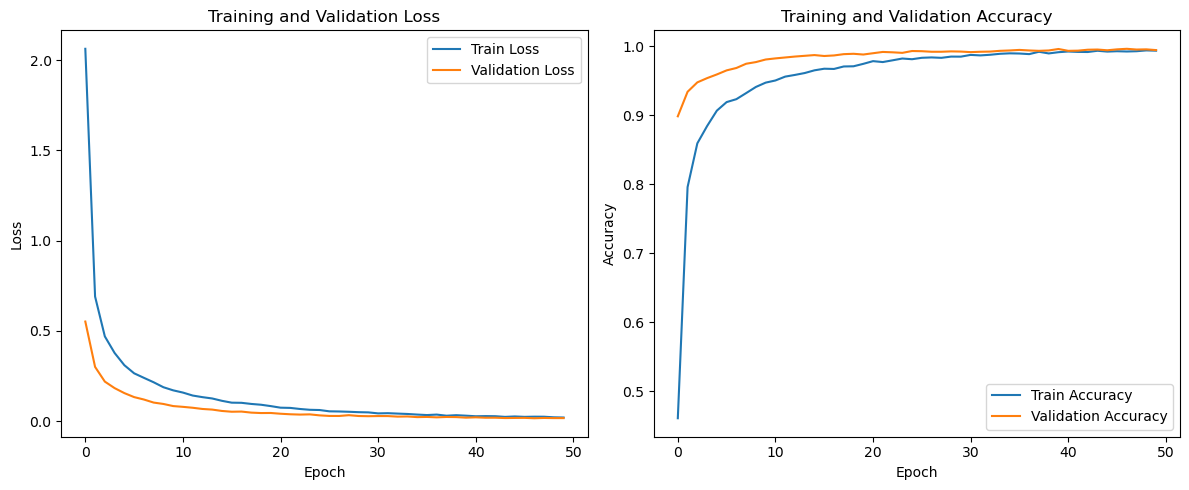

In [21]:
# Now we train the fusion model.
num_classes = 47
num_epochs = 50
learning_rate = 0.0001
dropout_rate = 0.3
image_embed_size = train_image_features[0].shape[1]
audio_embed_size = train_audio_features[0].shape[1]
hidden_dim = 512
# Create the fusion model
fusion_model = FusionANN(image_embed_size, audio_embed_size, hidden_dim, num_classes, dropout_rate)
fusion_model.to(device)
# Train the model.
_, history = train_fusion_model(fusion_model, 
                                train_image_features, 
                                train_audio_features, 
                                train_labels, 
                                val_image_features, 
                                val_audio_features, 
                                val_labels, 
                                num_epochs=num_epochs, 
                                batch_size=batch_size, 
                                learning_rate=learning_rate, 
                                device=device)
# Plot the training history
plot_training_history(history)


In [22]:
# Test the model on the test set.
test_image_features, test_audio_features, test_labels = extract_features(image_model, audio_model, test_loader, device)
test_accuracy, class_accuracy, weighted_f1 = evaluate_model(fusion_model, test_image_features, test_audio_features, test_labels, device)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

100%|██████████| 146/146 [00:02<00:00, 64.13it/s]


Test Accuracy: 0.9940
Weighted F1 Score: 0.9940


In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image

def unnormalize(img, mean, std):
    # Unnormalize an image tensor: expects img of shape (C, H, W)
    img = img.clone()  # avoid modifying the original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

def visualize_fusion_examples(fusion_model, image_model, audio_model, test_loader, device, num_examples=3):
    """
    Visualizes a few examples from the test set:
      - The raw bird image
      - The corresponding spectrogram (raw audio)
      - The predicted class (from the fusion model) and actual class.
    """
    fusion_model.eval()
    image_model.eval()
    audio_model.eval()
    
    examples = []
    count = 0

    # Iterate through the test loader to collect samples.
    with torch.no_grad():
        for batch in test_loader:
            # Assuming each batch is a dict with keys 'image', 'audio', 'label'
            images = batch['image']
            audios = batch['audio']
            labels = batch['label']
            # Move data to the device
            images = images.to(device)
            audios = audios.to(device)
            labels = labels.to(device)

            print(f"Image shape: {images.shape}")
            
            # Pass raw images and audios through their pre-trained models.
            image_features = image_model(images)    # e.g. shape: (batch_size, feat_dim1)
            audio_features = audio_model(audios)      # e.g. shape: (batch_size, feat_dim2)
            
            # Fusion model makes predictions from the extracted features.
            outputs = fusion_model(image_features, audio_features)
            _, predicted = torch.max(outputs, 1)
            
            batch_size = images.size(0)
            for i in range(batch_size):
                examples.append({
                    'image': images[i].cpu(), 
                    'audio': audios[i].cpu(), 
                    'pred': predicted[i].item(), 
                    'true': labels[i].item()
                })
                count += 1
                if count >= num_examples:
                    break
            if count >= num_examples:
                break

    # Create a grid with two rows (top: image, bottom: spectrogram) and num_examples columns.
    fig, axes = plt.subplots(nrows=2, ncols=num_examples, figsize=(5 * num_examples, 8))
    
    for idx, ex in enumerate(examples):
        # Process image: assume it's a tensor of shape (C, H, W).
        img_tensor = ex['image']
        # Unnormalize the image if needed (adjust mean and std as per your dataset)
        img_tensor = unnormalize(img_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # Convert to a PIL image for display.
        pil_img = to_pil_image(img_tensor)
        
        # Display the bird image with predicted and true class in the title.
        axes[0, idx].imshow(pil_img)
        axes[0, idx].set_title(f"Pred: {ex['pred']} | True: {ex['true']}", fontsize=12)
        axes[0, idx].axis('off')
        
        # Process audio: assume it is a spectrogram tensor with shape (1, freq, time)
        spec_tensor = ex['audio']
        spec_np = spec_tensor.squeeze(0).numpy()  # now shape is (freq, time)
        axes[1, idx].imshow(spec_np, aspect='auto', origin='lower', cmap='inferno')
        axes[1, idx].set_title("Spectrogram", fontsize=12)
        axes[1, idx].set_xlabel("Time")
        axes[1, idx].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()


Image shape: torch.Size([32, 1, 512])


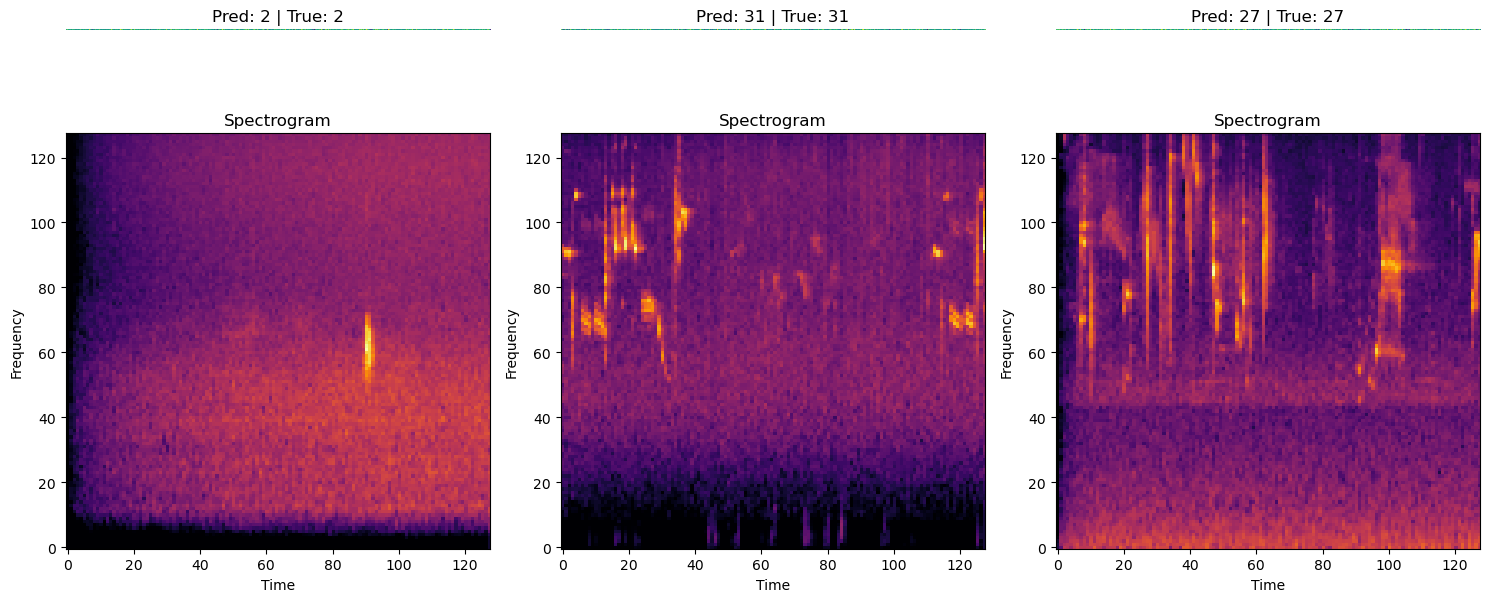

In [24]:
visualize_fusion_examples(fusion_model, image_model, audio_model, test_loader, device, num_examples=3)

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def evaluate_and_plot_confusion_matrix(fusion_model, test_image_features, test_audio_features, test_labels, device):
    fusion_model.eval()
    all_preds = []
    all_labels = []

    num_batches = len(test_image_features)

    with torch.no_grad():
        for batch_idx in range(num_batches):
            batch_image_features = test_image_features[batch_idx].to(device)
            batch_audio_features = test_audio_features[batch_idx].to(device)
            batch_labels = test_labels[batch_idx].to(device)

            outputs = fusion_model(batch_image_features, batch_audio_features)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Convert to flat numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    # Compute raw confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(47))

    # Plot full confusion matrix
    class_names = [f'Class {i+1}' for i in range(47)]
    plot_confusion_matrix(cm, classes=class_names, normalize=True)

    # Plot the diagonal (normalized per-class accuracy) as a heatmap
    plot_diagonal_accuracy(cm, class_names)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=8)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=6)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_diagonal_accuracy(cm, class_names):
    # Normalize row-wise
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
    
    # Extract diagonal (correct prediction rate per class)
    main_diag_normalized = np.diag(cm_normalized)
    main_diag_row_normalized = main_diag_normalized.reshape(1, -1)

    plt.figure(figsize=(20, 3))
    plt.imshow(main_diag_row_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Diagonal of Confusion Matrix")
    plt.colorbar(pad=0.01)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=8)
    plt.yticks([])

    for j in range(main_diag_row_normalized.shape[1]):
        value = main_diag_row_normalized[0, j]
        plt.text(j, 0, format(value, '.2f'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if value > main_diag_row_normalized.max() / 2.0 else "black",
                 fontsize=8)

    plt.xlabel('Class')
    plt.ylabel('Correct Predictions (Normalized)')
    plt.tight_layout()
    plt.show()


Normalized confusion matrix


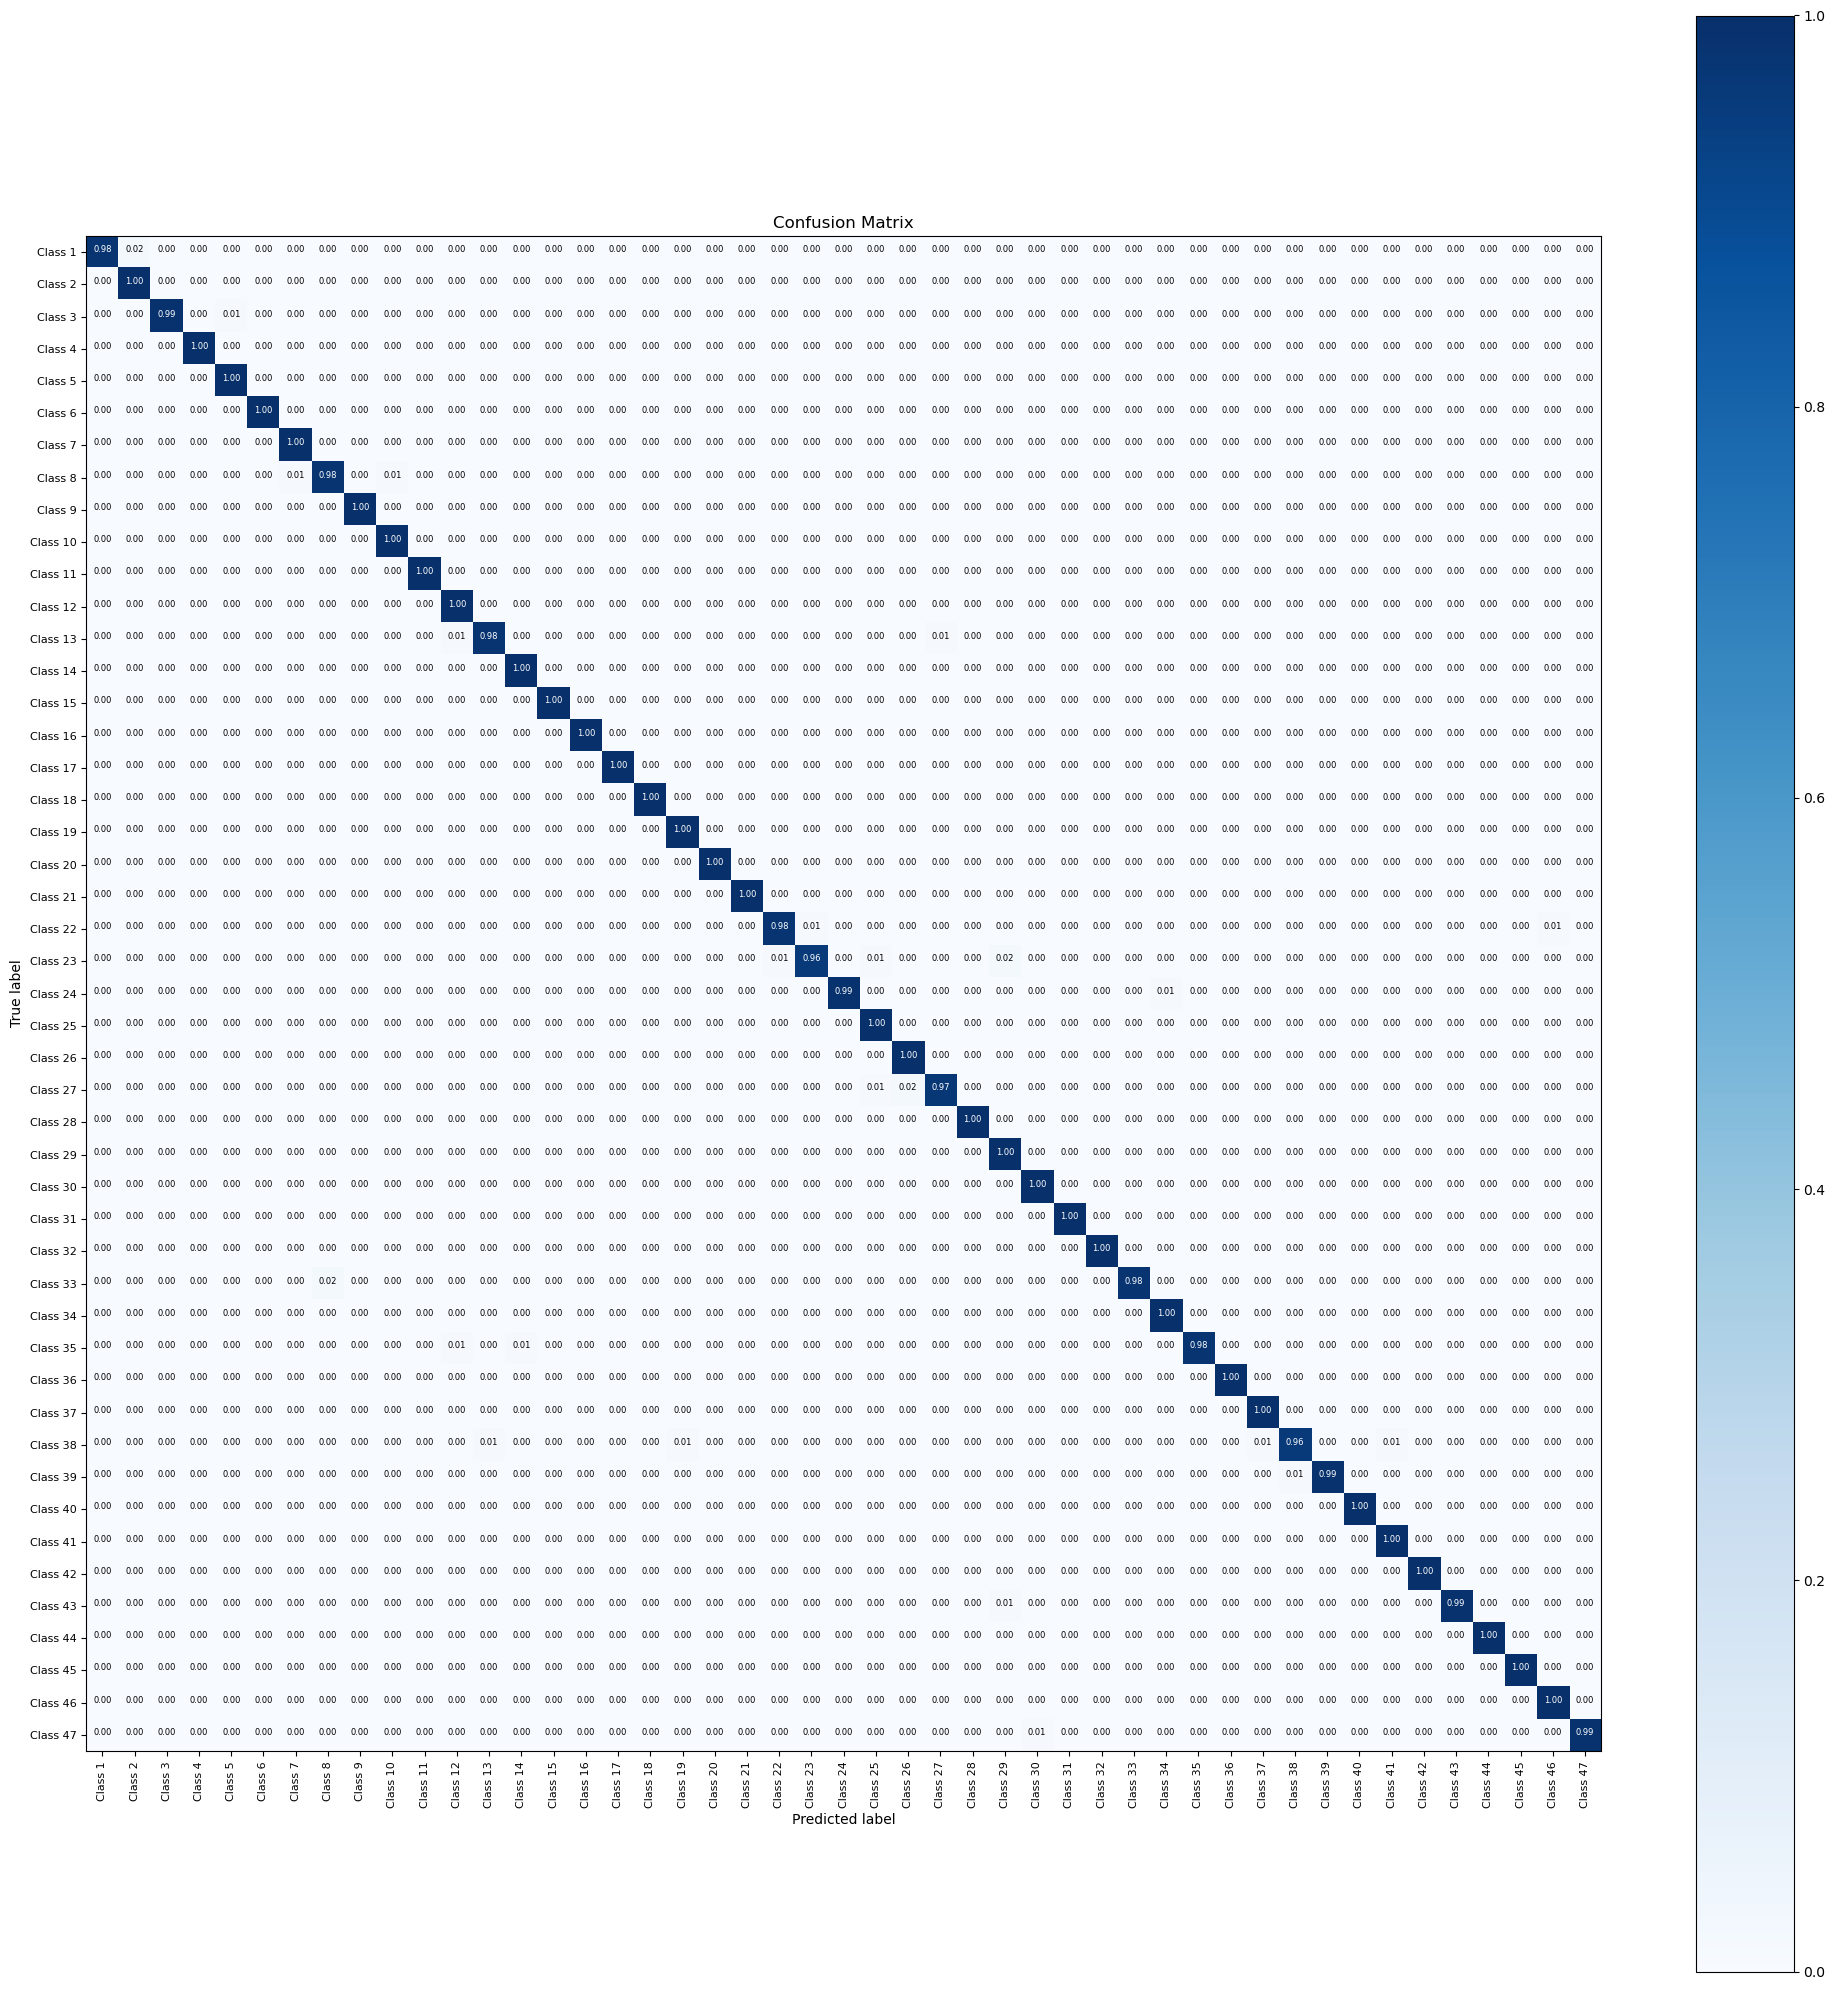

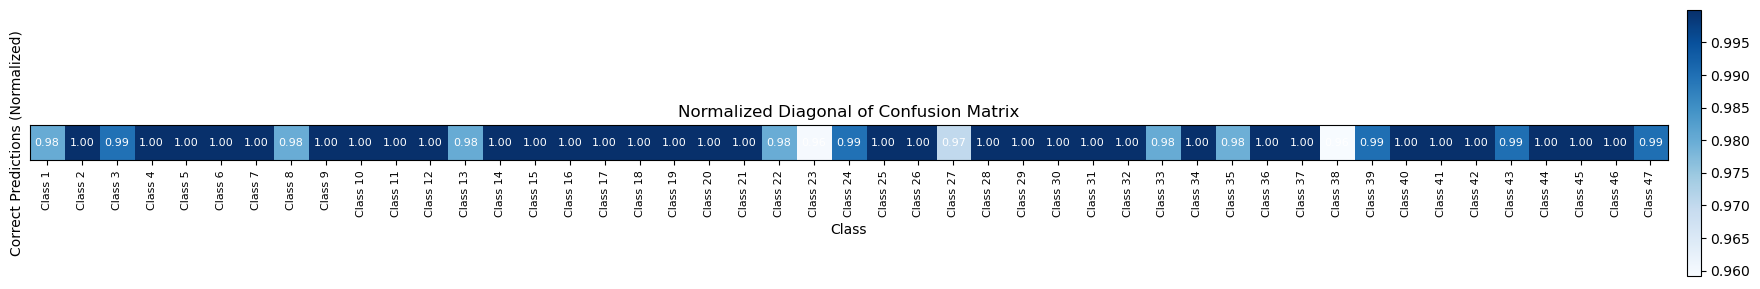

In [26]:
evaluate_and_plot_confusion_matrix(fusion_model, test_image_features, test_audio_features, test_labels, device)

In [27]:
"""DEMO ROUTINE"""

'DEMO ROUTINE'

In [28]:
# Now load the image test dataset from the .pt file.
raw_images_dataset = torch.load("../../Data/images_test_dataset.pt")

/var/folders/s8/7wj664s92gx_89p1xhcwbq800000gn/T/ipykernel_4758/4069416094.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_images_dataset = torch.load("../../Data/im

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.64].


Dataset label: 875
Available keys in mapping: [539, 352, 317, 979, 848, 949, 877, 774, 802, 847, 832, 513, 946, 527, 536, 957, 543, 856, 902, 852, 796, 746, 871, 400, 830, 756, 875, 964, 886, 810, 950, 851, 987, 766, 900, 910, 753, 835, 450, 790, 831, 914, 888, 669, 315, 749, 889]


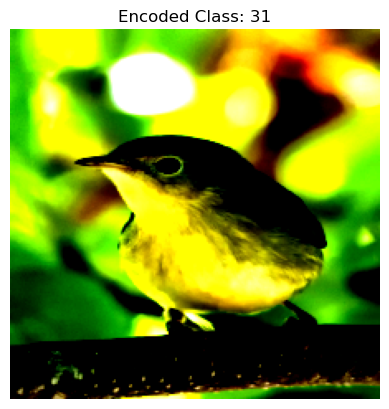

In [29]:
import pickle
import matplotlib.pyplot as plt

# Retrieve the image tensor and label from the dataset
image_tensor = raw_images_dataset['images'][2]  # Tensor shape: (C, H, W)
label = raw_images_dataset['labels'][2]         # Original label (as a tensor)

# Load the label mappings from the pickle file.
with open('label_mappings.pkl', 'rb') as f:
    label_mappings = pickle.load(f)

# Convert the label to a Python int
label_int = label.item()

# Convert mapping keys from torch tensors to ints (if necessary)
int_key_mapping = {
    k.item() if hasattr(k, "item") else k: v
    for k, v in label_mappings['id_to_index'].items()
}

# Optional: Print out available keys to debug the mismatch
print("Dataset label:", label_int)
print("Available keys in mapping:", list(int_key_mapping.keys()))

# Retrieve the encoded label with a default if not found
encoded_label = int_key_mapping.get(label_int, "Unknown")

# Convert the image tensor from CHW to HWC format for display
image_np = image_tensor.permute(1, 2, 0)

# Plot the image with its encoded label
plt.figure()
plt.imshow(image_np)
plt.title(f"Encoded Class: {encoded_label}")
plt.axis("off")
plt.show()

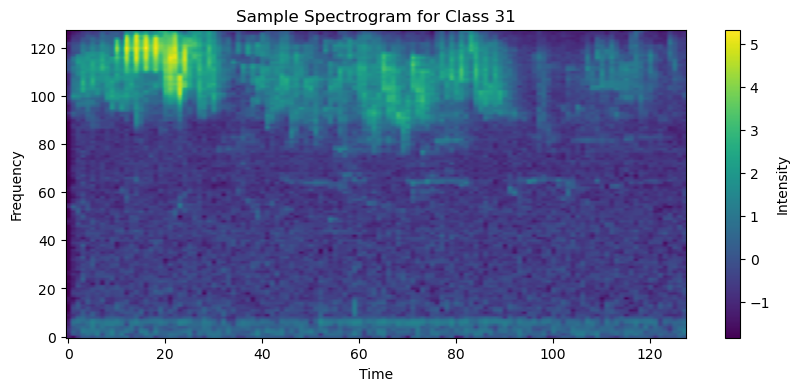

In [30]:
# Extract the audio tensor and visualise it.
import matplotlib.pyplot as plt

# Retrieve the spectrogram tensor from the dataset
spectrogram_tensor = audio_dataset[19][0] # Remove the channel dimension if needed
spectrogram_tensor_squeezed = spectrogram_tensor.squeeze(0)  # Assuming shape (1, freq, time)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_tensor_squeezed, aspect='auto', origin='lower')
plt.title("Sample Spectrogram for Class 31")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Intensity")
plt.show()

In [31]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Assume these are already defined:
# - device (e.g., torch.device("cuda") or torch.device("cpu"))
# - image_tensor: a tensor for an image, shape: [C, H, W]
# - spectrogram_tensor: a tensor for a spectrogram, shape: [channels, freq, time]
# - audio_model: your pre-trained audio model (e.g. SpecCNN)
# - fusion_model: your trained fusion model (e.g. FusionANN)

# -------------------------------
# 1. Image Feature Extraction using ResNet18
# -------------------------------
# Add batch dimension if needed.
if image_tensor.dim() == 3:
    image_input = image_tensor.unsqueeze(0).to(device)
else:
    image_input = image_tensor.to(device)

# Load pre-trained ResNet18 and remove the final fully connected layer.
resnet18 = models.resnet18(pretrained=True).to(device)
# Remove the final classification layer to get the feature extractor.
resnet18_features = torch.nn.Sequential(*list(resnet18.children())[:-1]).to(device)
resnet18_features.eval()

with torch.no_grad():
    img_features = resnet18_features(image_input)  # shape: (1, 512, 1, 1)
    img_features = img_features.view(img_features.size(0), -1)  # shape: (1, 512)
    img_features = image_model(img_features)  # shape: (1, feature_dim)

# -------------------------------
# 2. Audio Feature Extraction (using your audio model)
# -------------------------------
# Ensure the spectrogram has a batch dimension.
if spectrogram_tensor.dim() == 3:
    audio_input = spectrogram_tensor.unsqueeze(0).to(device)
else:
    audio_input = spectrogram_tensor.to(device)

with torch.no_grad():
    audio_features = audio_model(audio_input)  # Expected shape: (1, feature_dim)

# -------------------------------
# 3. Fusion Prediction
# -------------------------------
fusion_model.eval()
with torch.no_grad():
    # The fusion model takes image and audio features and outputs class scores.
    fusion_output = fusion_model(img_features, audio_features)
    predicted_class = fusion_output.argmax(dim=1).item()

print("Predicted Fusion Class:", predicted_class)

/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/ECE421/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Fusion Class: 31
